# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [137]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [116]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [117]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 20, alternate_sign=False, ngram_range=(1,2),analyzer='word',stop_words='english')
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [118]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='data/moviereviews_train.tsv', my_random_seed=50)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 1048576)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [119]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

/Users/skyladfah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(


{'Pos': 10022, 'Neg': 9978, 'TP': 6169, 'TN': 3869, 'FP': 6109, 'FN': 3853, 'Accuracy': 0.5019, 'Precision': 0.5024433946896889, 'Recall': 0.6155457992416683, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [120]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [121]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [122]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [123]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10019, 'TN': 9977, 'FP': 1, 'FN': 3, 'Accuracy': 0.9998, 'Precision': 0.9999001996007985, 'Recall': 0.9997006585511874, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [298]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1.0)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'alpha_1.0')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'alpha_1.0'}


In [299]:
rdg2 = linear_model.RidgeClassifier(alpha=100.0)
rdg2.fit(X_train, y_train)

rdg2_performance_train = BinaryClassificationPerformance(rdg2.predict(X_train), y_train, 'alpha_100.0')
rdg2_performance_train.compute_measures()
print(rdg2_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'alpha_100.0'}


In [300]:
rdg3 = linear_model.RidgeClassifier(alpha=500.0)
rdg3.fit(X_train, y_train)

rdg3_performance_train = BinaryClassificationPerformance(rdg3.predict(X_train), y_train, 'alpha_500.0')
rdg3_performance_train.compute_measures()
print(rdg3_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'alpha_500.0'}


In [301]:
rdg4 = linear_model.RidgeClassifier(alpha=5000.0)
rdg4.fit(X_train, y_train)

rdg4_performance_train = BinaryClassificationPerformance(rdg4.predict(X_train), y_train, 'alpha_5000')
rdg4_performance_train.compute_measures()
print(rdg4_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'alpha_5000'}


In [302]:
rdg5 = linear_model.RidgeClassifier(alpha=10000.0)
rdg5.fit(X_train, y_train)

rdg5_performance_train = BinaryClassificationPerformance(rdg5.predict(X_train), y_train, 'alpha_10000')
rdg5_performance_train.compute_measures()
print(rdg5_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'alpha_10000'}


In [303]:
from sklearn import linear_model
rdg0 = linear_model.RidgeClassifier()
rdg0.fit(X_train, y_train)

rdg0_performance_train = BinaryClassificationPerformance(rdg0.predict(X_train), y_train, 'original')
rdg0_performance_train.compute_measures()
print(rdg0_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'original'}


### MODEL: Random Forest Classifier

In [125]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 8777, 'TN': 5854, 'FP': 4124, 'FN': 1245, 'Accuracy': 0.73155, 'Precision': 0.6803348577629641, 'Recall': 0.8757732987427659, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

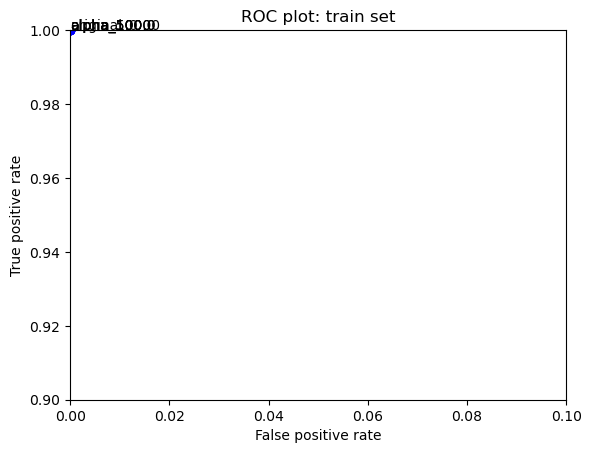

In [304]:
# fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
fits = [rdg0_performance_train,rdg_performance_train,rdg2_performance_train,rdg3_performance_train,rdg4_performance_train,rdg5_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.1, 0.9, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [258]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [259]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
76
After seeing the low-budget shittier versions of the \Universal Soldier\" franchise, I hoped and prayed that Van Damme reprised his role as Luc Devoreaux in a second Unisol movie. Well, it seemed this prayer was answered, but not the way I hoped. Universial Soldier 2 is just intense as poetry reading at your local library. No, even that would be more intriguing . The fight sequences are top-notch, Bruce Lee quality, which is the only redeeming factor in this entire pathetic excuse for a motion picture. That and having former WCW tough-guy legend \"Goldberg\" playing the villain. However, placing Goldberg as Seth's sidekick lieutenant would've been better.<br /><br />We offended me the most was the setting of the movie itself. It's like some film school students slapped it together. The plot holes are that bigger than Kanye West's ego is what really did this movie in. For example: Luc's daughter, Hillary looks like she's at least 11-13 years old and the f

The Education of Little Tree is just not as good as it could have been. Little Tree's education is about things like the circle of life and how you should look at a star to help you. Whatever happened to the three R's? Readin' 'Ritin' and 'Rithmetic? When the idiot back talks the teacher at the boarding school place he starts crying and talking to the sky. Oh my gosh. Sure, the lady was a little harsh, but then James Cromwell's character comes and takes him away, leaving the audience thinking that Little Tree was absolutely right. He should learn to adapt to new discipline. Those were the times! Talking to a star is not going to change a thing! Little Tree needs to learn that his adoring guardians are not always right.
* * * * * * * * * 
7596
Where to start? This is probably one of the worst movies I have ever seen. The editing is the worst ever, the sound effects were awful and the sound editing was whacked. Most of the movie all one could here is the crappy kicking effects, with mudd

13725
I just finished watching Going Overboard. I have to say that we should send every copy of this film to Iraq and make them watch. I even tried to get a blind women to watch this and she turned it off in like 20 min. Adam Sandler could not find a better project than this? As for the writing, if thats what you want to call it, those responsible should be forced to watch this movie forever in Hell!! I believe that somewhere I read that the budget for this film was $10,000 and they were way under. Did Wallmart get a good deal on this? Every store has a big huge bin of this crap sitting on the sales floor. The only good thing about this movie is you can use the DVD as a coaster, or trade it to a friend, but then they might not be your friend anymore!!
* * * * * * * * * 
13761
I had recently been watching Johnny Test in an attempt to find humor in it. I failed, horribly. Cartoon Network usually has a tendency to make their shows enjoyable by all audiences, but Johnny Test is \entertainm

19818
this is the first time I'm writing a comment on a movie on IMDb. but i had to write it for this one. its 3 hrs of unadulterated torture. from the starting u get the idea that the movie is gonna be bad. the acting is pathetic. I'm a big fan of Ajay devgan (loved him in bhagat singh) but he is at his worst in this movie. amitabh seems to have worked hard for this one, but somehow the fear is missing. prashant raj is a non actor. and the most irritating part of the movie is nisha kothari. i have no clue why the director took her in this movie. the background score is repetitive. somehow i felt that ramu tried to repeat a sarkar, the color theme, the background score, the camera angles, but it didn't work. PLEASE Don't WATCH IT
* * * * * * * * * 
19876
**SPOILERS*** Slow as molasses mummy movie involving this expiation in the Valley of the Kings in Egypt that has to be aborted in order to keep the native population, who are at the time revolting against British rule, from finding out

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [260]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 1513, 'TN': 971, 'FP': 1551, 'FN': 965, 'Accuracy': 0.4968, 'Precision': 0.493798955613577, 'Recall': 0.6105730427764327, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [261]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 1970, 'TN': 1945, 'FP': 577, 'FN': 508, 'Accuracy': 0.783, 'Precision': 0.77345897133883, 'Recall': 0.7949959644874899, 'desc': 'svm_test'}


### MODEL: logistic regression

In [262]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 1961, 'TN': 1977, 'FP': 545, 'FN': 517, 'Accuracy': 0.7876, 'Precision': 0.7825219473264166, 'Recall': 0.79136400322841, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [263]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 1829, 'TN': 1644, 'FP': 878, 'FN': 649, 'Accuracy': 0.6946, 'Precision': 0.675655707425194, 'Recall': 0.7380952380952381, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [133]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 1960, 'TN': 1989, 'FP': 533, 'FN': 518, 'Accuracy': 0.7898, 'Precision': 0.7862013638186923, 'Recall': 0.7909604519774012, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [285]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'alpha_1.0')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2196, 'TN': 2099, 'FP': 423, 'FN': 282, 'Accuracy': 0.859, 'Precision': 0.8384879725085911, 'Recall': 0.8861985472154964, 'desc': 'alpha_1.0'}


In [286]:
rdg2_performance_test = BinaryClassificationPerformance(rdg2.predict(X_test), y_test, 'alpha_100.0')
rdg2_performance_test.compute_measures()
print(rdg2_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2196, 'TN': 2099, 'FP': 423, 'FN': 282, 'Accuracy': 0.859, 'Precision': 0.8384879725085911, 'Recall': 0.8861985472154964, 'desc': 'alpha_100.0'}


In [288]:
rdg3_performance_test = BinaryClassificationPerformance(rdg3.predict(X_test), y_test, 'alpha_500.0')
rdg3_performance_test.compute_measures()
print(rdg3_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2196, 'TN': 2099, 'FP': 423, 'FN': 282, 'Accuracy': 0.859, 'Precision': 0.8384879725085911, 'Recall': 0.8861985472154964, 'desc': 'alpha_500.0'}


In [289]:
rdg4_performance_test = BinaryClassificationPerformance(rdg4.predict(X_test), y_test, 'alpha_5000.0')
rdg4_performance_test.compute_measures()
print(rdg4_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2196, 'TN': 2100, 'FP': 422, 'FN': 282, 'Accuracy': 0.8592, 'Precision': 0.8388082505729565, 'Recall': 0.8861985472154964, 'desc': 'alpha_5000.0'}


In [307]:
rdg5_performance_test = BinaryClassificationPerformance(rdg5.predict(X_test), y_test, 'alpha_10000.0')
rdg5_performance_test.compute_measures()
print(rdg5_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2195, 'TN': 2101, 'FP': 421, 'FN': 283, 'Accuracy': 0.8592, 'Precision': 0.8390672782874617, 'Recall': 0.8857949959644875, 'desc': 'alpha_10000.0'}


In [291]:
rdg0_performance_test = BinaryClassificationPerformance(rdg0.predict(X_test), y_test, 'original')
rdg0_performance_test.compute_measures()
print(rdg0_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2196, 'TN': 2099, 'FP': 423, 'FN': 282, 'Accuracy': 0.859, 'Precision': 0.8384879725085911, 'Recall': 0.8861985472154964, 'desc': 'original'}


### MODEL: Random Forest Classifier

In [135]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2127, 'TN': 1409, 'FP': 1113, 'FN': 351, 'Accuracy': 0.7072, 'Precision': 0.6564814814814814, 'Recall': 0.8583535108958837, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

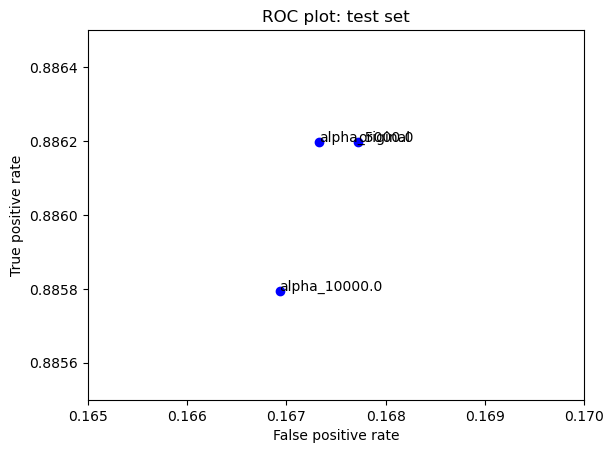

In [308]:
# fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
# fits = [rdg0_performance_test,rdg_performance_test,rdg2_performance_test,rdg3_performance_test,rdg4_performance_test,rdg5_performance_test]
fits = [rdg0_performance_test,rdg4_performance_test,rdg5_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0.165, 0.17, 0.8855, 0.8865])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/moviereviews_test.tsv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5596


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,1
2,5828_4,1
3,7186_2,1
4,12128_7,0


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation